In [4]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from tempfile import TemporaryDirectory

from Models import BigGenerator
from Tools import KL, batchKL

from tqdm import trange

print(torch.__version__)


1.4.0


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
from Experiments.foong_sparse import Setup
setup=Setup(device)
model=setup._model
param_count=setup.param_count
projection=setup.projection

In [7]:
FG=BigGenerator(5,param_count, device).to(device)
FG.load_state_dict(torch.load('mlruns/45/7485b4d65e9e4fd0a6012b9e571baddd/artifacts/model.pt')['state_dict'])
theta_FG=FG(9999).detach()

Text(0.5, 1.0, 'FuNNeVI')

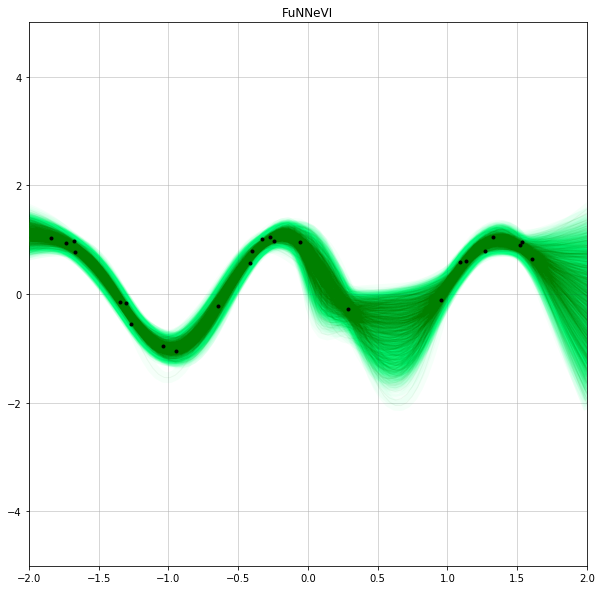

In [8]:
fig=setup.makePlot(FG(1000).detach(),device)
plt.title('FuNNeVI')

In [10]:
theta_HMC=torch.load('mlruns/57/803a95bd9ed945aeaf5aa1a2cc71365d/artifacts/Foong_sparse_803a95bd9ed945aeaf5aa1a2cc71365d.pt').to(device)

torch.Size([9999, 151])

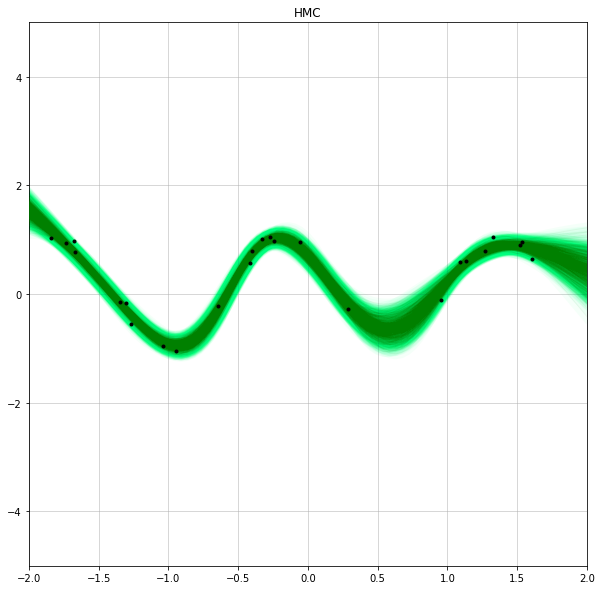

In [49]:
fig=setup.makePlot(theta_HMC[0::10],device)
plt.title('HMC')
theta_HMC.shape

In [11]:
G=BigGenerator(5,param_count, device).to(device)
G.load_state_dict(torch.load('mlruns/49/03b3e1b158c344d3813b3293d34ae6cb/artifacts/model.pt')['state_dict'])
theta_G=G(9999).detach()

Text(0.5, 1.0, 'GeNNeVI')

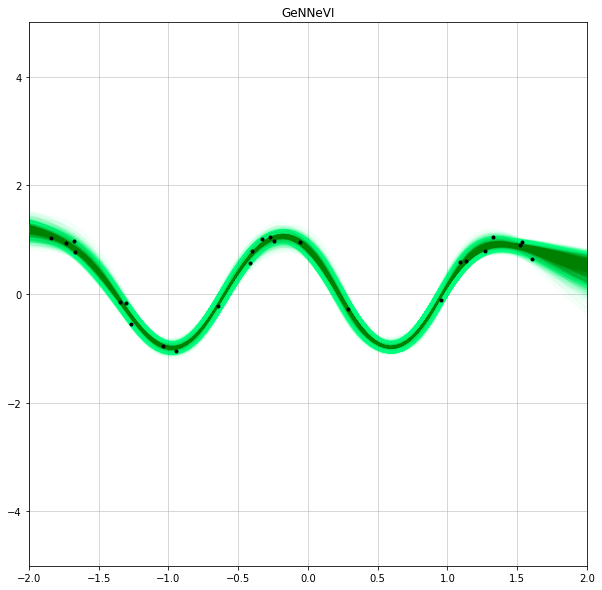

In [51]:
fig=setup.makePlot(G(1000).detach(),device)
plt.title('GeNNeVI')

# Parameter space 

In [12]:
models={'HMC':theta_HMC,
        'GeNNeVI':theta_G,
        'FuNNeVI':theta_FG}
for m in models:
    for n in models:
        if not n == m: 
            K=KL(models[m], models[n],k=1,device=device)
            print('KL('+m+','+n+'):'+str(K))

KL(HMC,GeNNeVI):tensor(43.3582, device='cuda:0')
KL(HMC,FuNNeVI):tensor(34.5078, device='cuda:0')
KL(GeNNeVI,HMC):tensor(219.7404, device='cuda:0')
KL(GeNNeVI,FuNNeVI):tensor(237.0059, device='cuda:0')
KL(FuNNeVI,HMC):tensor(547.6502, device='cuda:0')
KL(FuNNeVI,GeNNeVI):tensor(581.2609, device='cuda:0')


In [13]:
import itertools
models_pairs=list(itertools.combinations(models.items(),2))


# Function space 

In [25]:
def FuKL(t,s,k=10,n=100, m=20):
    assert t.shape == s.shape
    K=torch.Tensor(n)
    for i in range(n):
        t_, s_= projection(t, s, m, 1.)
        K[i]=KL(t_, s_, k=k,device=device)
    return K.mean()

print('KL in function space L_2([-2,2])')
for (m,s),(n,t) in models_pairs:
        K=FuKL(s, t)
        K_=FuKL(t,s)
        print('KL('+m+','+n+'):'+str(K.item())+'   '+'KL('+n+','+m+'):'+str(K_.item()))
        print('J('+m+','+n+'):'+str(0.5*(K.item()+K_.item())))

KL in function space L_2([-2,2])
KL(HMC,GeNNeVI):23.615705490112305   KL(GeNNeVI,HMC):38.28678894042969
J(HMC,GeNNeVI):30.951247215270996
KL(HMC,FuNNeVI):13.844049453735352   KL(FuNNeVI,HMC):14.90097427368164
J(HMC,FuNNeVI):14.372511863708496
KL(GeNNeVI,FuNNeVI):35.77198028564453   KL(FuNNeVI,GeNNeVI):20.629844665527344
J(GeNNeVI,FuNNeVI):28.200912475585938


# Predictive space

In [16]:
import scipy.stats as st

def pred_div(s,t,X):
    J=torch.Tensor(X.shape[0])
    K=torch.Tensor(X.shape[0])
    K_=torch.Tensor(X.shape[0])
    W=torch.Tensor(X.shape[0])
    for x in range(X.shape[0]):
        K[x]=KL(s[:,x].unsqueeze(-1),t[:,x].unsqueeze(-1),k=300)
        K_[x]=KL(t[:,x].unsqueeze(-1),s[:,x].unsqueeze(-1),k=300)
        W[x]=st.wasserstein_distance(s[:,x].cpu().numpy(),t[:,x].cpu().numpy())
    J=0.5*(K+K_)
    return [K, K_, J, W]

In [17]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['GeNNeVI']).squeeze()
metrics_GE=pred_div(s,t,X)

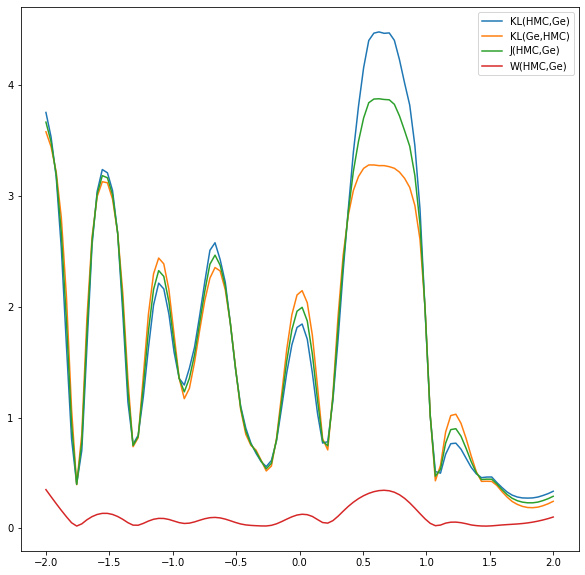

In [18]:
plt.subplots(figsize=(10,10))
for m in metrics_GE:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Ge)','KL(Ge,HMC)','J(HMC,Ge)', 'W(HMC,Ge)'])


In [19]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['FuNNeVI']).squeeze()
metrics_FU=pred_div(s,t,X)

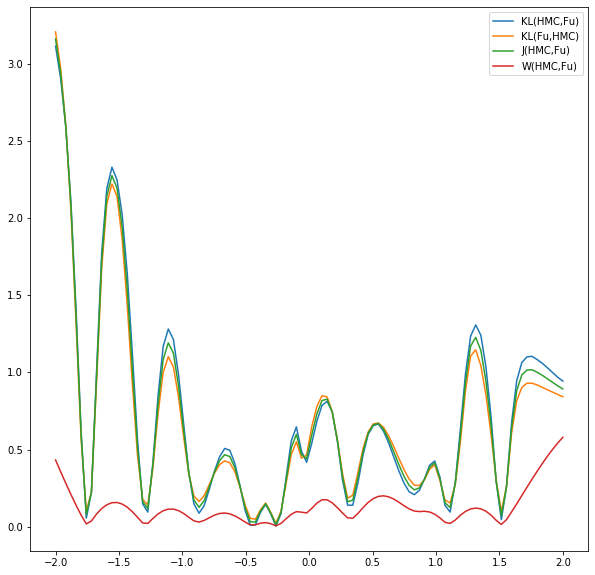

In [20]:
plt.subplots(figsize=(10,10))
for m in metrics_FU:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Fu)','KL(Fu,HMC)','J(HMC,Fu)', 'W(HMC,Fu)'])


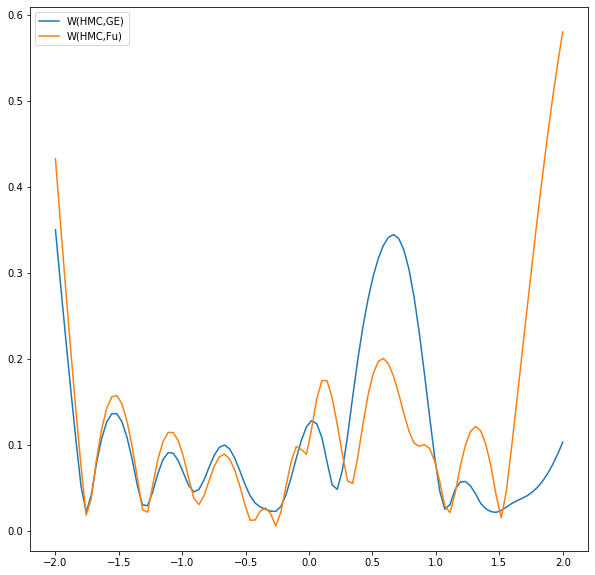

In [21]:
plt.subplots(figsize=(10,10))
plt.plot(X.cpu(),metrics_GE[3].cpu())
plt.plot(X.cpu(),metrics_FU[3].cpu())
plt.legend( ['W(HMC,GE)', 'W(HMC,Fu)'])

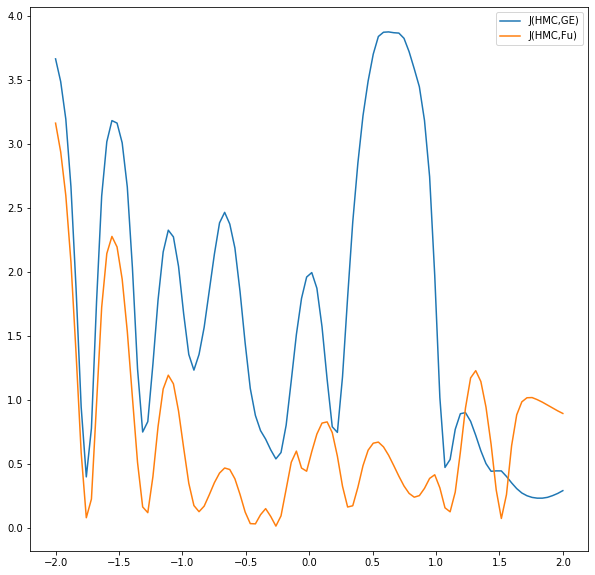

In [23]:
plt.subplots(figsize=(10,10))
plt.plot(X.cpu(),metrics_GE[2].cpu())
plt.plot(X.cpu(),metrics_FU[2].cpu())
plt.legend( ['J(HMC,GE)', 'J(HMC,Fu)'])

# T-sne 

In [39]:
thetas=[theta_HMC,theta_G,theta_FG]
thetas=[t[::10] for t in thetas]

size_sample=thetas[0].shape[0]

theta=torch.cat(thetas,dim=0)
colors=torch.cat([torch.zeros(size_sample),0.1*torch.ones(size_sample),0.2*torch.ones(size_sample)])
theta.shape

torch.Size([3000, 151])

In [32]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=5)
X_embedded_ =myTSNE.fit_transform(theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.7654460668563843


(3000, 2)

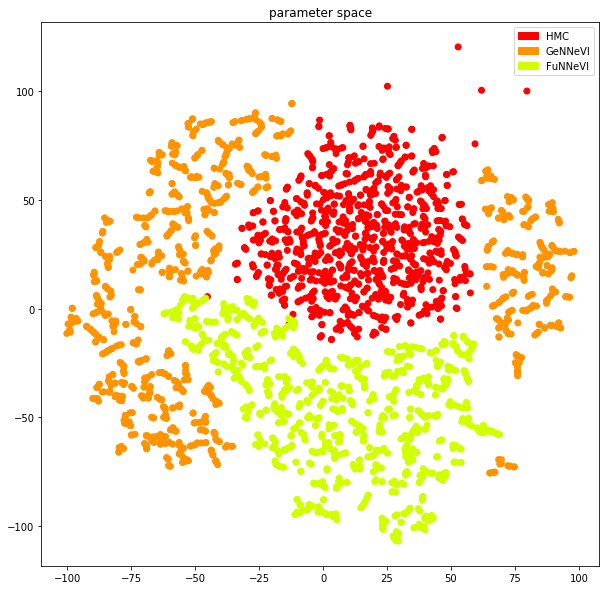

In [34]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))




G1_patch = mpatches.Patch(color=cmap(0.), label='HMC')
G2_patch = mpatches.Patch(color=cmap(0.1), label='GeNNeVI')
G3_patch = mpatches.Patch(color=cmap(0.2), label='FuNNeVI')



#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_[:,0],X_embedded_[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.title('parameter space')
plt.show()


In [40]:
X=torch.linspace(-2,2,100).to(device)
thetas_proj=[model(X,t).squeeze() for t in thetas]
theta_proj=torch.cat(thetas_proj,dim=0)


In [47]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=50)
X_embedded_proj =myTSNE.fit_transform(theta_proj.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.1494033336639404


(3000, 2)

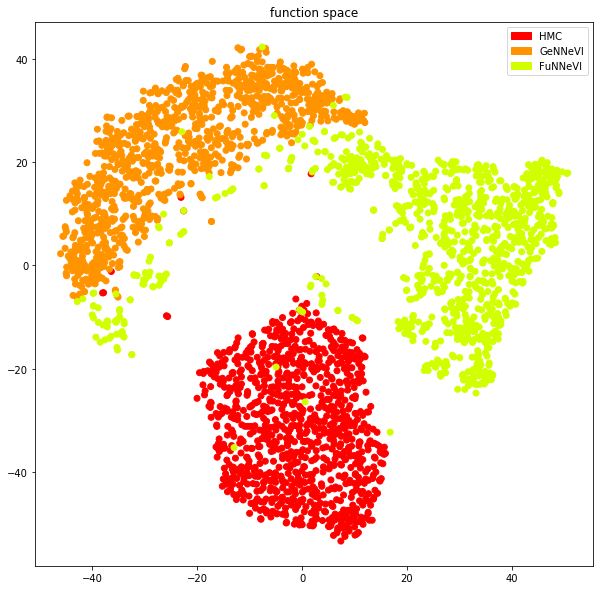

In [48]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))



G1_patch = mpatches.Patch(color=cmap(0.), label='HMC')
G2_patch = mpatches.Patch(color=cmap(0.1), label='GeNNeVI')
G3_patch = mpatches.Patch(color=cmap(0.2), label='FuNNeVI')


#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_proj[:,0],X_embedded_proj[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.title('function space')
plt.show()
